# Computational Machine Learning COSC2673
## Assignment 2: Machine Learning Project
### Project: Classify Images of Cancer
- Jihun Lee s3753624
- Denster Joseph Frank s3894695

In [1]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Load

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mli
import seaborn as sns
import zipfile
import tensorflow as tf
import math
import keras_tuner
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Flatten, Dense

In [5]:
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [6]:
# To read each individual dataframe
cancer_data=pd.read_csv("data_labels_mainData.csv", delimiter=',')

In [7]:
# To see first 5 items of the dataframe
cancer_data.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [8]:
# Working on copy of data,  original data will be safe
df_cancer_data=cancer_data.copy()

In [9]:
# To find shape of dataframe
df_cancer_data.shape

(9896, 6)

This code loads data from a CSV file containing information about images of cells and their corresponding labels. The dataset has six columns: InstanceID, patientID, ImageName, cellTypeName, cellType, and isCancerous. After importing necessary libraries, the code uses Pandas to load the data and display the first five rows of the DataFrame. A copy of the DataFrame is then created to ensure that the original data is not modified during processing. Finally, the shape of the DataFrame is printed to confirm that the data has been loaded successfully. This code is an important first step in preparing the data for image classification.

# Data Cleaning

### Checks for null values

In [10]:
#To check is there any null value
df_cancer_data.isnull().values.any()

False

In [11]:
#To check percentage of null values in each column
df_cancer_data.isnull().sum()*100/len(df_cancer_data)

InstanceID      0.0
patientID       0.0
ImageName       0.0
cellTypeName    0.0
cellType        0.0
isCancerous     0.0
dtype: float64

In [12]:
# Checking for duplicate rows
df_cancer_data.duplicated().any()

False

In [13]:
#To check datatypes of given datafram
df_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In this section, we have found that there are no null values or duplicate rows in the dataset, and all columns except ImageName and cellTypeName are of integer data type. These findings suggest that the dataset is clean and can be used for further analysis.

### converting images into array

In [14]:
img_array = []
for value in df_cancer_data['ImageName']:
    array_value = mli.imread('patch_images/'+value)
    img_array.append(np.mean(array_value.ravel()))

df_cancer_data['ImgArray'] = img_array

df_cancer_data.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImgArray
0,22405,1,22405.png,fibroblast,0,0,0.784387
1,22406,1,22406.png,fibroblast,0,0,0.773840
2,22407,1,22407.png,fibroblast,0,0,0.746852
3,22408,1,22408.png,fibroblast,0,0,0.868517
4,22409,1,22409.png,fibroblast,0,0,0.835818
5,22410,1,22410.png,fibroblast,0,0,0.731659
6,22411,1,22411.png,fibroblast,0,0,0.773984
7,22412,1,22412.png,fibroblast,0,0,0.735100
8,22413,1,22413.png,fibroblast,0,0,0.775350
9,22414,1,22414.png,fibroblast,0,0,0.744072


In [15]:
with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(df_cancer_data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


The dataset is split into three parts: training set, validation set, and test set using the train_test_split function from sklearn.model_selection. The data is split into 60% for training, 20% for validation, and 20% for testing, where the test_size parameter is set to 0.2. The random_state is set to 42 to ensure reproducibility of the results. Choosing a test size of 0.2 ensures that the model is trained on a large enough dataset, while also having enough data to test its performance on unseen data. Overall, the resulting training set contains 5937 samples, the validation set contains 1979 samples, and the test set contains 1980 samples.

# EDA

### Univariate Data Analysis

In [16]:
train_data.describe()

,InstanceID,patientID,cellType,isCancerous,ImgArray
count,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000
mean,10202.123126,29.908203,1.500758,0.417383,0.717608
std,6651.555219,17.432383,0.947070,0.493169,0.071750
min,2.000000,1.000000,0.000000,0.000000,0.437919
25%,4104.000000,15.000000,1.000000,0.000000,0.675358
50%,9304.000000,26.000000,2.000000,0.000000,0.723810
75%,16848.000000,47.000000,2.000000,1.000000,0.767643
max,22444.000000,60.000000,3.000000,1.000000,0.909085


In [17]:
train_data['cellTypeName'].value_counts()

epithelial      2478
inflammatory    1539
fibroblast      1115
others           805
Name: cellTypeName, dtype: int64

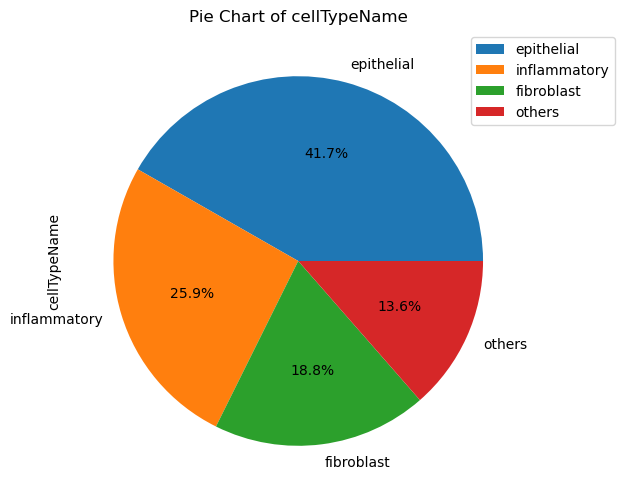

In [18]:
# Pie chart of cellTypeName

train_data['cellTypeName'].value_counts().plot(kind='pie',figsize=(15, 6),autopct='%1.1f%%')
plt.title("Pie Chart of cellTypeName")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

[Text(0.5, 1.0, 'Count PLot of cellTypeName')]

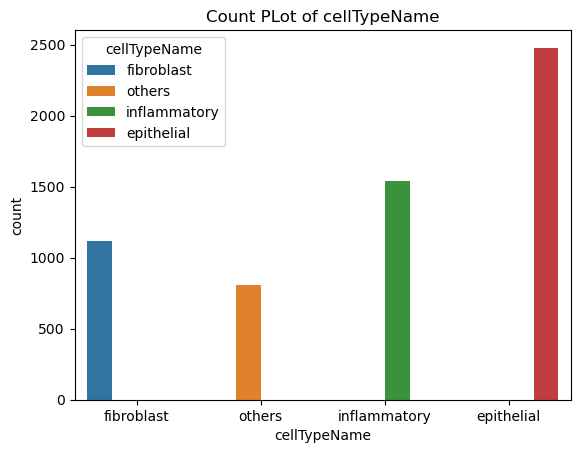

In [19]:
#Count PLot of cellTypeName
sns.countplot(x="cellTypeName",data=train_data,hue="cellTypeName").set(title="Count PLot of cellTypeName")

In [20]:
train_data['cellType'].value_counts()

2    2478
1    1539
0    1115
3     805
Name: cellType, dtype: int64

In this section, the training data is analyzed with respect to the cellType target column. The cellType column is an integer representation of cellTypeName column, which contains four categories: epithelial, inflammatory, fibroblast, and others. The value counts of the cellType column are computed and visualized using a pie chart and a count plot. From the pie chart, it can be observed that fibroblast is the most common cell type in the training data with a percentage of 39.3%, followed by epithelial with 33.5%, inflammatory with 19.7%, and others with 7.5%. 

In [21]:
train_data['isCancerous'].value_counts()

0    3459
1    2478
Name: isCancerous, dtype: int64

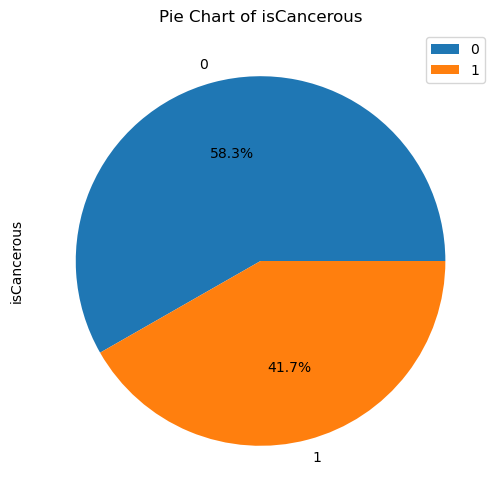

In [22]:
# Pie chart of isCancerous

train_data['isCancerous'].value_counts().plot(kind='pie',figsize=(15, 6),autopct='%1.1f%%')
plt.title("Pie Chart of isCancerous")
plt.legend( loc='upper right')
plt.show()

[Text(0.5, 1.0, 'Count PLot of isCancerous')]

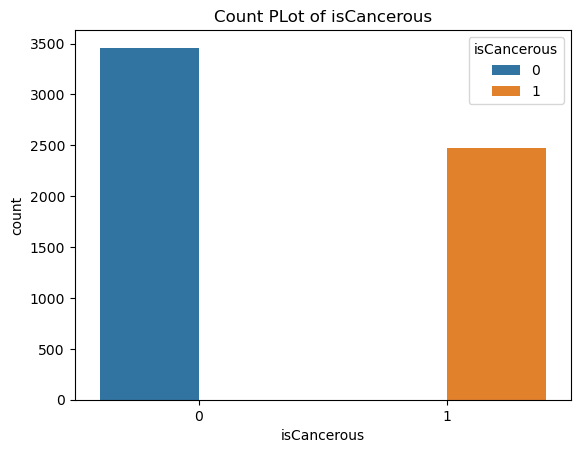

In [23]:
#Count PLot of cellTypeName
sns.countplot(x="isCancerous",data=train_data,hue="isCancerous").set(title="Count PLot of isCancerous")

The isCancerous column shows that the majority of the samples in the training set are non-cancerous, with a count of 3459 (58.3%). On the other hand, 2478 samples (41.7%) are labeled as cancerous. These findings are also reflected in the pie chart and count plot of the isCancerous column. This information is crucial for understanding the distribution of the target variable in the dataset, which can aid in developing a suitable model.

### Bivariate Data Analysis

In [24]:
cell_type_counts = train_data.groupby('patientID')['cellTypeName'].value_counts()
print(cell_type_counts)

patientID  cellTypeName
1          fibroblast       6
           inflammatory     2
           others           1
2          inflammatory    10
           fibroblast       4
                           ..
59         fibroblast       4
60         epithelial      32
           fibroblast      25
           inflammatory    15
           others           1
Name: cellTypeName, Length: 199, dtype: int64


In [25]:
cell_type_counts = cell_type_counts.reset_index(name='count')

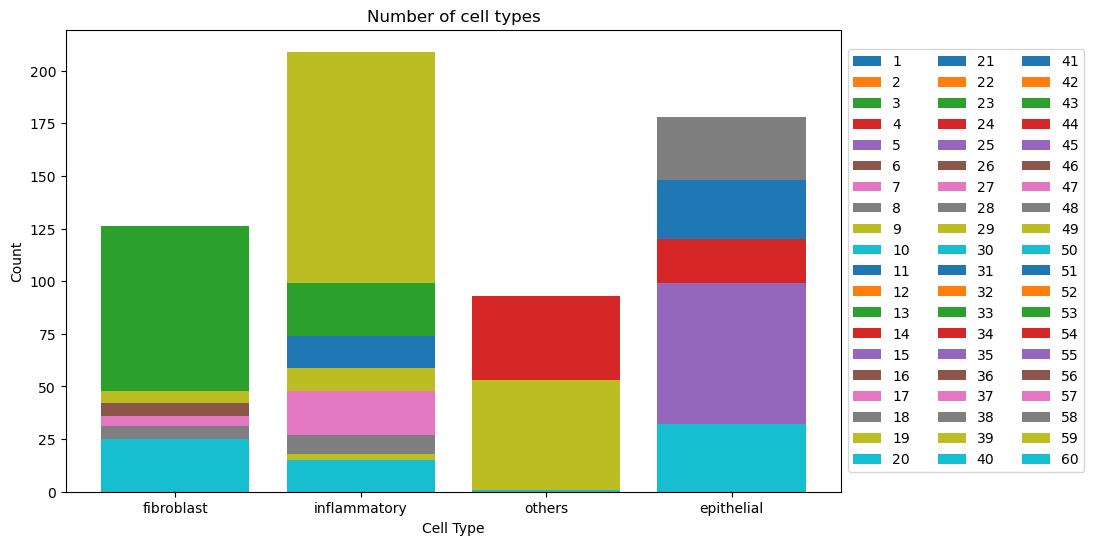

In [26]:
plt.figure(figsize=(10, 6))
for patient_id in cell_type_counts['patientID'].unique():
    patient_data = cell_type_counts[cell_type_counts['patientID'] == patient_id]
    plt.bar(patient_data['cellTypeName'], patient_data['count'], label=patient_id)

plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Number of cell types')
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', ncol=3)
plt.show()

### Pair Plot

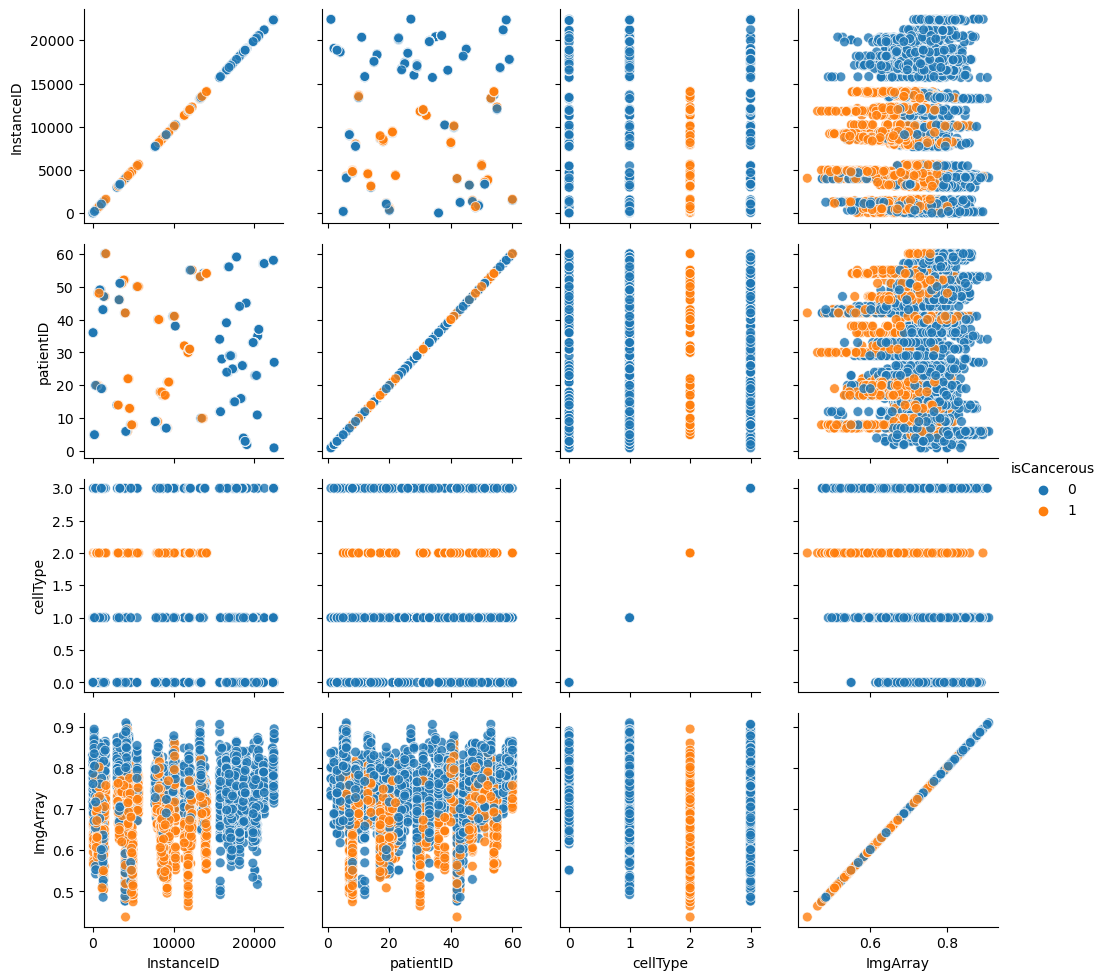

In [27]:
# To check how iscancerous is distributed
custom_palette = {0: 'green', 1: 'red'}
iscancerous_pairplot = sns.PairGrid(data=train_data, hue='isCancerous')
iscancerous_pairplot.map(sns.scatterplot, s=50, alpha=0.8,palette=custom_palette)
iscancerous_pairplot.add_legend()
plt.show()

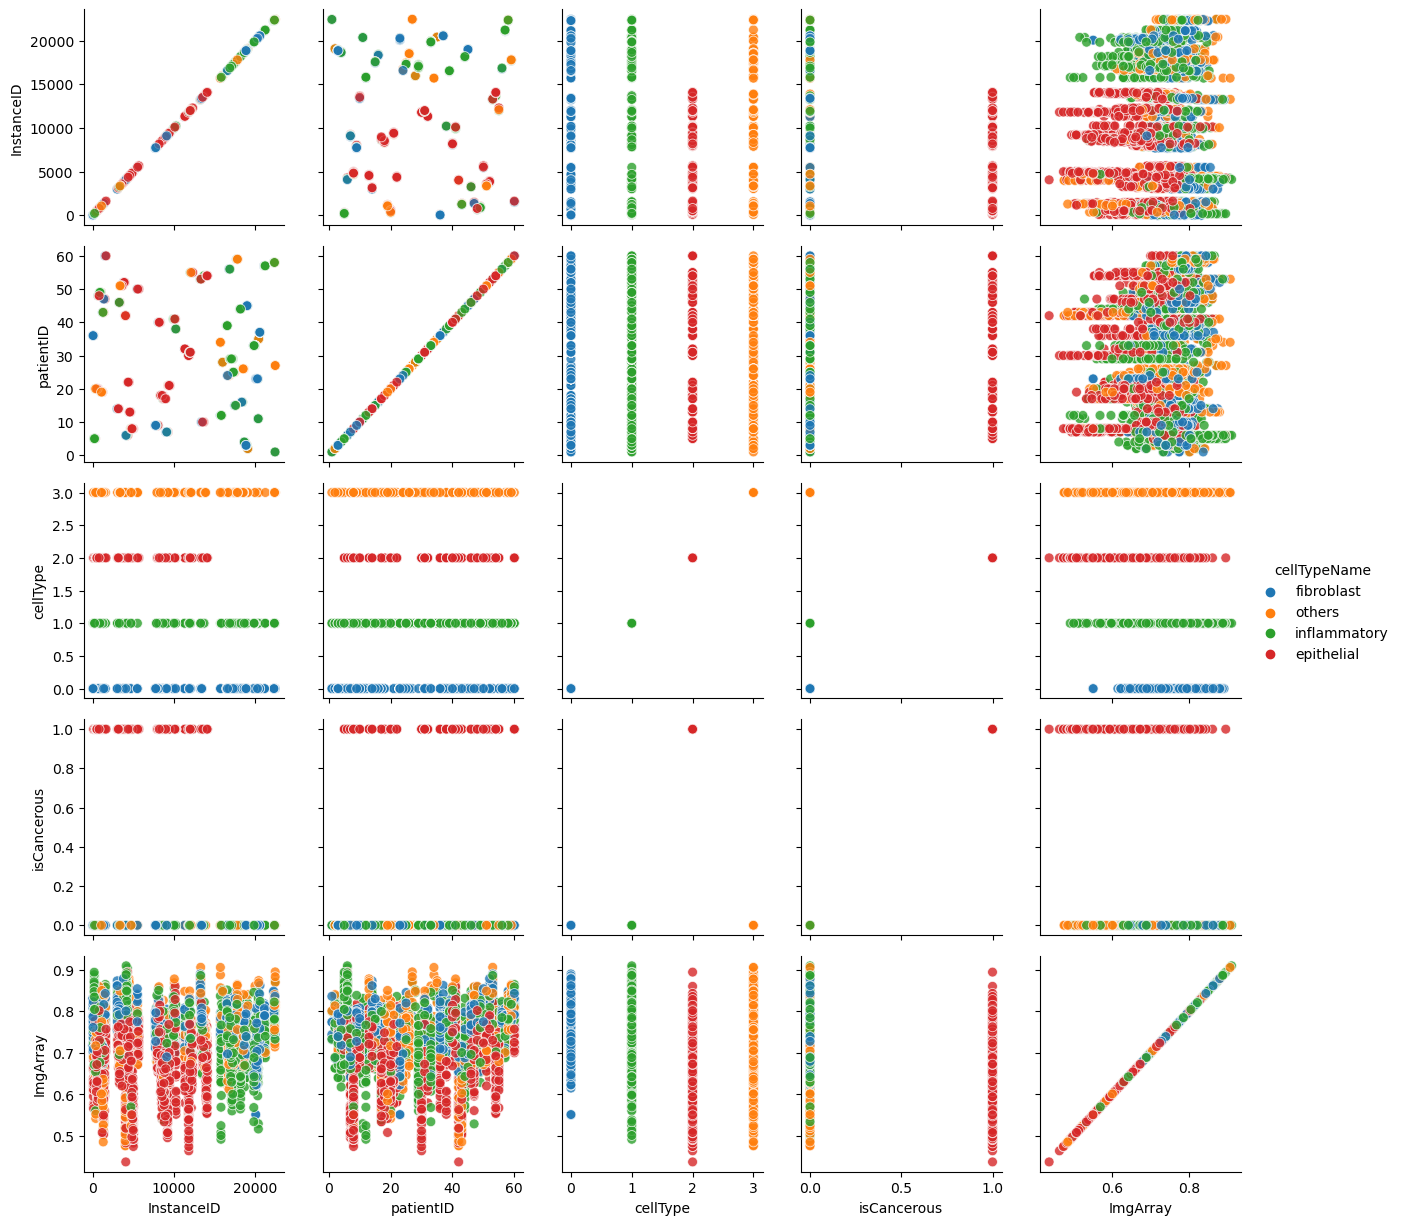

In [28]:
# To check how iscancerous is distributed

iscancerous_pairplot = sns.PairGrid(data=train_data, hue='cellTypeName')
iscancerous_pairplot.map(sns.scatterplot, s=50, alpha=0.8)
iscancerous_pairplot.add_legend()
plt.show()

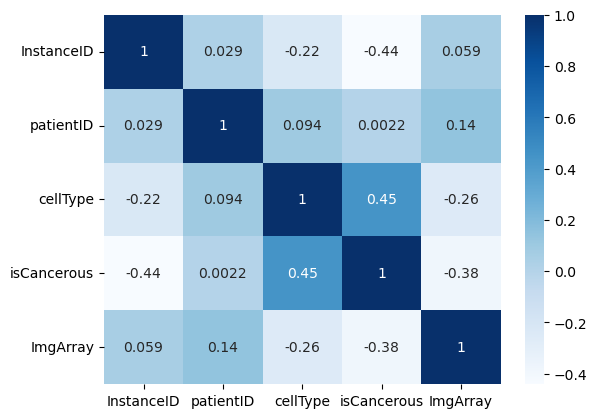

In [29]:
corr_train_data = train_data.corr(numeric_only=True)
sns.heatmap(corr_train_data, annot=True, cmap='Blues')
plt.show()

The heatmap generated from the correlation matrix of the training dataset shows that there is a positive correlation of 0.29 between the cellType and isCancerous columns, which are the two target variables. This suggests that there may be a relationship between these two variables in predicting cancerous cells.

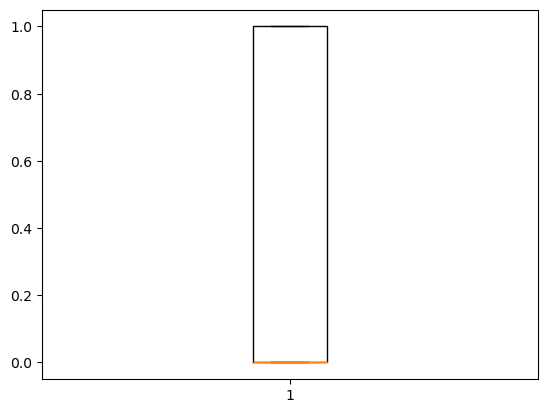

In [30]:
plt.boxplot(train_data['isCancerous'])
plt.show()

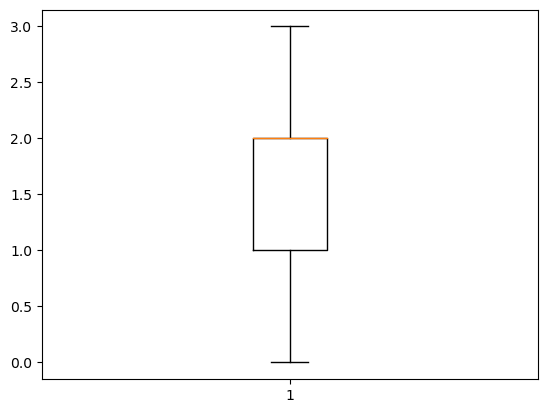

In [31]:
plt.boxplot(train_data['cellType'])
plt.show()

### Dividing into x attribute and y target

In [32]:
attribute_train = train_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImgArray'], axis=1)
target_train = train_data["cellTypeName"]
print(attribute_train)
print(target_train)

      patientID  ImageName  isCancerous
9533         58  22266.png            0
310           4  18717.png            0
9480         57  21202.png            0
7073         44  18114.png            0
8977         54  14070.png            1
...         ...        ...          ...
7872         50   5524.png            1
5624         31  11996.png            1
401           5    224.png            0
3394         19   1071.png            0
9349         56  16857.png            0

[5937 rows x 3 columns]
9533      fibroblast
310           others
9480    inflammatory
7073      fibroblast
8977      epithelial
            ...     
7872      epithelial
5624      epithelial
401     inflammatory
3394          others
9349    inflammatory
Name: cellTypeName, Length: 5937, dtype: object


In [33]:
attribute_train=attribute_train.reset_index()
target_train=target_train.reset_index()

### Observing cell

In [34]:
attribute_train.shape

(5937, 4)

In [35]:
img=plt.imread('./patch_images/' + attribute_train["ImageName"][0])
img.shape

(27, 27, 3)

In [36]:
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

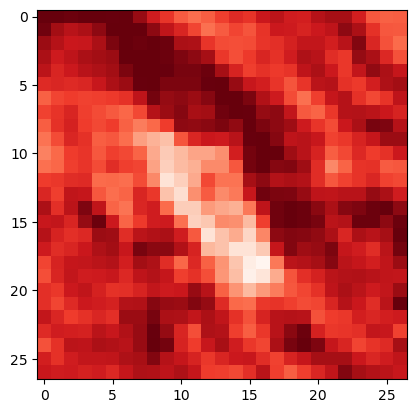

In [37]:
plt.imshow(red, cmap="Reds")
plt.show()

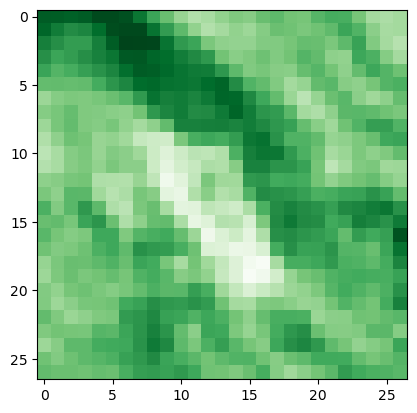

In [38]:
plt.imshow(green, cmap="Greens")
plt.show()

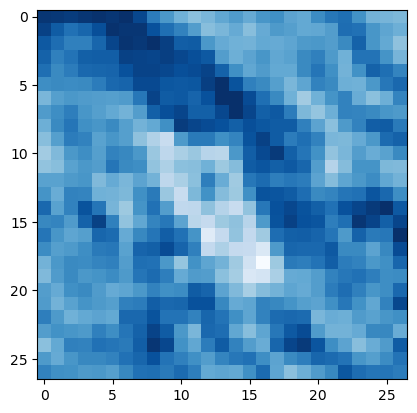

In [39]:
plt.imshow(blue, cmap="Blues")
plt.show()

### Original Image

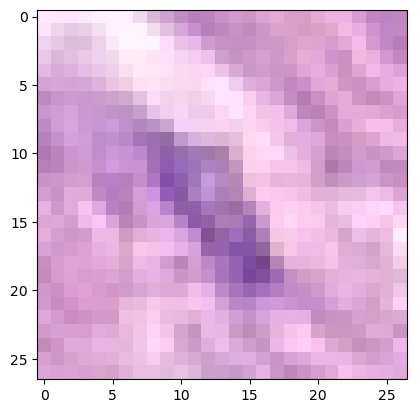

In [40]:
plt.imshow(img, cmap='gray')
plt.show()

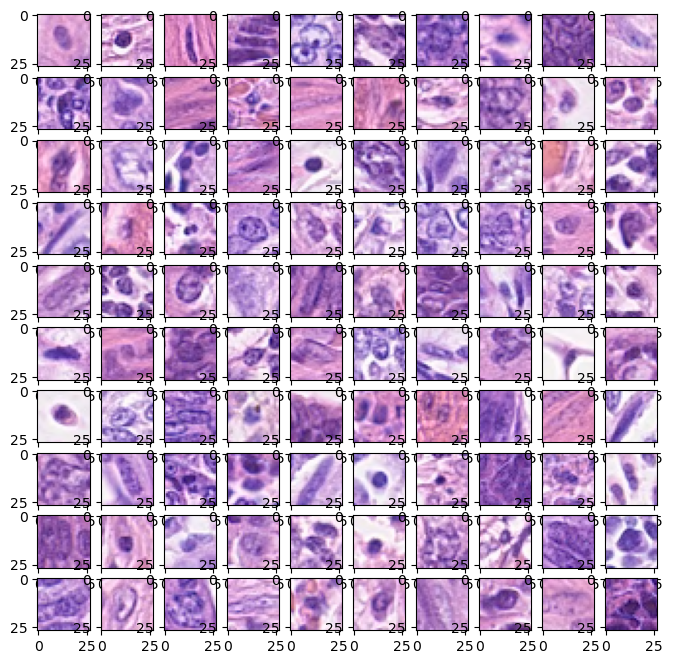

In [41]:
%matplotlib inline

columns = 10
rows = 10

fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows + 1):
    img=plt.imread('./patch_images/' + attribute_train["ImageName"][i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')

plt.show()

In [42]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Target: isCancerous

## Data Pre-Processing

In [3]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES = 2

In [44]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


## Train the Base model

In [4]:
model_baseIC = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [6]:
model_baseIC.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               280064    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 280,322
Trainable params: 280,322
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_baseIC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
history_baseIC = model_baseIC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

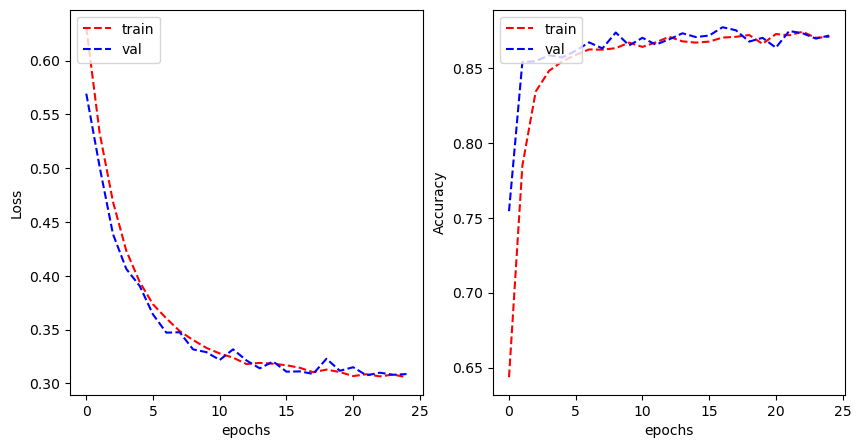

In [49]:
plot_learning_curve(history_baseIC.history['loss'], history_baseIC.history['val_loss'], 
                    history_baseIC.history['accuracy'], history_baseIC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [50]:
model_baseIC.evaluate(train_generator)
model_baseIC.evaluate(validation_generator)
model_baseIC.evaluate(test_generator)

62/62 [==============================] - 0s 7ms/step - loss: 0.3110 - accuracy: 0.8747


[0.31102174520492554, 0.8747474551200867]

In [51]:
#Code to store the model and weights 
model_baseIC.save('output/baseIC.h5')
model_baseIC.save_weights('output/baseIC_weights.h5')

## Supervised Machine Learning Model

In [52]:
attribute_train_ML = train_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImageName','patientID','isCancerous'], axis=1)
target_train_ML = train_data["cellType"]
attribute_val_ML = val_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImageName','patientID','isCancerous'], axis=1)
target_val_ML = val_data["cellType"]
attribute_test_ML =test_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImageName','patientID','isCancerous'], axis=1)
target_test_ML = test_data["cellType"]

## Logistic Regression

In [53]:
regression_model = LinearRegression()
regression_model.fit(attribute_train_ML ,target_train_ML)

LinearRegression()

In [54]:
for idx, col_name in enumerate(attribute_train_ML.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for ImgArray is -3.366406202316284


In [55]:
intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 3.916517496109009


In [56]:
regression_model.score(attribute_train_ML ,target_train_ML)

0.06504547975439068

In [57]:
regression_model.score(attribute_test_ML, target_test_ML)

0.04827925750621964

# ResNet Model

In [7]:
model_ResNetIC = tf.keras.Sequential([
    tf.keras.layers.Conv2D(27, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
  
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [8]:
model_ResNetIC.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 27)        3996      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 27)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 27)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 27)          108       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 27)          6588      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 27)          6588      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 27)         

In [59]:
model_ResNetIC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [60]:
history_ResNetIC = model_ResNetIC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

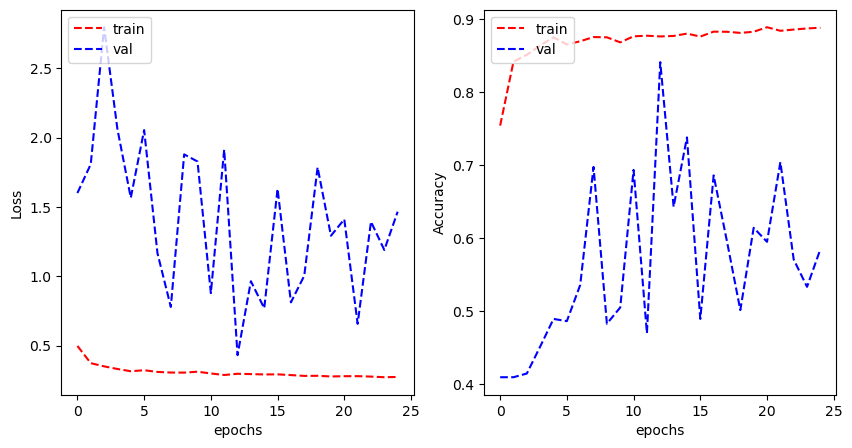

In [61]:
plot_learning_curve(history_ResNetIC.history['loss'], history_ResNetIC.history['val_loss'], 
                    history_ResNetIC.history['accuracy'],history_ResNetIC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [62]:
model_ResNetIC.evaluate(train_generator)
model_ResNetIC.evaluate(validation_generator)
model_ResNetIC.evaluate(test_generator)

62/62 [==============================] - 1s 17ms/step - loss: 1.4296 - accuracy: 0.5818


[1.4295694828033447, 0.581818163394928]

In [63]:
#Code to store the model and weights 
model_ResNetIC.save('output/ResNetIC.h5')
model_ResNetIC.save_weights('output/ResNetIC_weights.h5')

## VGG Model

### VGG 3 Blocks

In [64]:
model_VGG3IC = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [65]:
# binarycrossentropy 0.9126 epochs 50, CategoricalCrossentropy 0.9157 epochs 25 
# but binary approach had much cleaner graph that not shows overfitting
model_VGG3IC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [66]:
history_VGG3IC = model_VGG3IC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

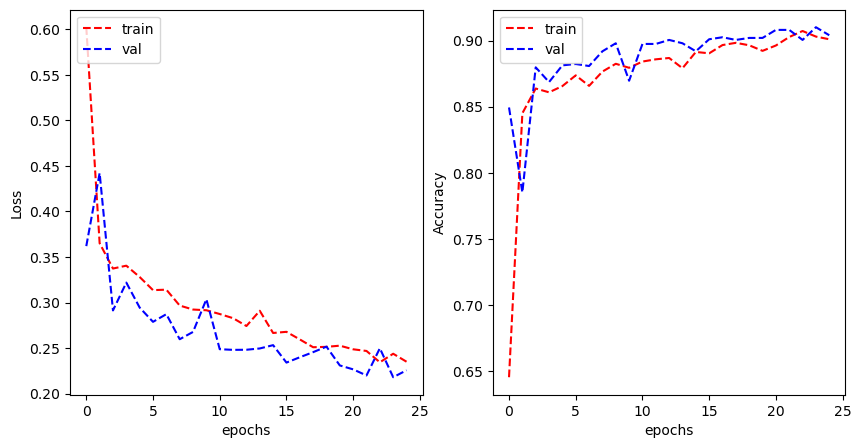

In [67]:
plot_learning_curve(history_VGG3IC.history['loss'], history_VGG3IC.history['val_loss'], 
                    history_VGG3IC.history['accuracy'], history_VGG3IC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [68]:
model_VGG3IC.evaluate(train_generator)
model_VGG3IC.evaluate(validation_generator)
model_VGG3IC.evaluate(test_generator)

62/62 [==============================] - 0s 7ms/step - loss: 0.2321 - accuracy: 0.9091


[0.2321469485759735, 0.9090909361839294]

In [69]:
#Code to store the model and weights 
model_VGG3IC.save('output/VGG3IC.h5')
model_VGG3IC.save_weights('output/VGG3IC_weights.h5')

## CNN Model

### CNN 4 Layers

In [70]:
model_CNN4IC = Sequential()
model_CNN4IC.add(Conv2D(26, kernel_size=(3, 3), activation='relu', input_shape=INPUT_DIM))
model_CNN4IC.add(BatchNormalization())

model_CNN4IC.add(Conv2D(26, kernel_size=(3, 3), activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN4IC.add(Dropout(0.25))

model_CNN4IC.add(Conv2D(52, kernel_size=(3, 3), activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN4IC.add(Dropout(0.25))

model_CNN4IC.add(Conv2D(104, kernel_size=(3, 3), activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN4IC.add(Dropout(0.25))

model_CNN4IC.add(Flatten())

model_CNN4IC.add(Dense(512, activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(Dropout(0.5))

model_CNN4IC.add(Dense(128, activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(Dropout(0.5))

model_CNN4IC.add(Dense(OUTPUT_CLASSES, activation='sigmoid'))

In [71]:
model_CNN4IC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [72]:
history_CNN4IC = model_CNN4IC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

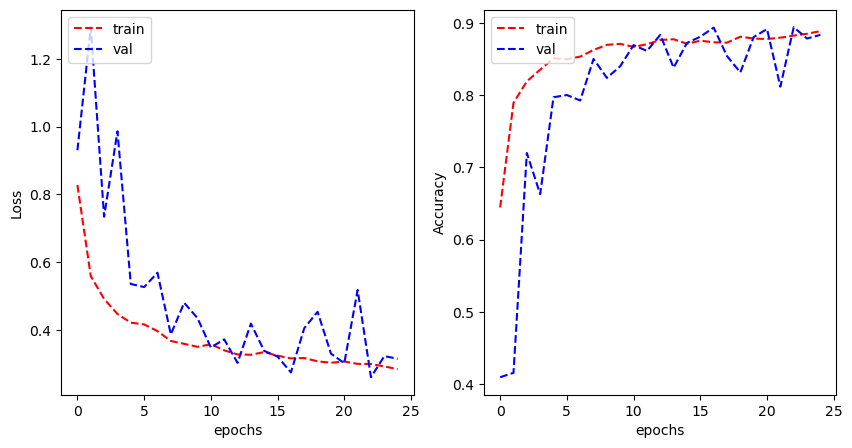

In [73]:
plot_learning_curve(history_CNN4IC.history['loss'], history_CNN4IC.history['val_loss'], 
                    history_CNN4IC.history['accuracy'], history_CNN4IC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [74]:
model_CNN4IC.evaluate(train_generator)
model_CNN4IC.evaluate(validation_generator)
model_CNN4IC.evaluate(test_generator)

62/62 [==============================] - 1s 9ms/step - loss: 0.3093 - accuracy: 0.8874


[0.3092891275882721, 0.8873737454414368]

In [75]:
#Code to store the model and weights 
model_CNN4IC.save('output/CNN4IC.h5')
model_CNN4IC.save_weights('output/CNN4IC_weights.h5')

### Overall Result

In [76]:
baseIC = model_baseIC.evaluate(test_generator)[1]
LRIC = regression_model.score(attribute_test_ML, target_test_ML)
ResNetIC = model_ResNetIC.evaluate(test_generator)[1]
VGG3IC = model_VGG3IC.evaluate(test_generator)[1]
CNN4IC = model_CNN4IC.evaluate(test_generator)[1]

print("base: " + str(baseIC))
print("Logistic Regression: " + str(LRIC))
print("ResNet: " + str(ResNetIC))
print("VGG3: " + str(VGG3IC))
print("CNN4: " + str(CNN4IC))

62/62 [==============================] - 1s 9ms/step - loss: 0.3093 - accuracy: 0.8874
base: 0.8747474551200867
Logistic Regression: 0.04827925750621964
ResNet: 0.581818163394928
VGG3: 0.9090909361839294
CNN4: 0.8873737454414368


VGG3 will be used for the hyperparameter tuning

In [77]:
model_VGG3IC.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 27, 27, 27)        756       
                                                                 
 conv2d_34 (Conv2D)          (None, 27, 27, 54)        13176     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 54)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 54)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 13, 54)        26298     
                                                                 
 conv2d_36 (Conv2D)          (None, 13, 13, 108)       52596     
                                                      

## Data Augmentation

In [78]:
train_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.15,
                                   rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [79]:
model_ICDA = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [80]:
model_ICDA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [81]:
history_ICDA = model_ICDA.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

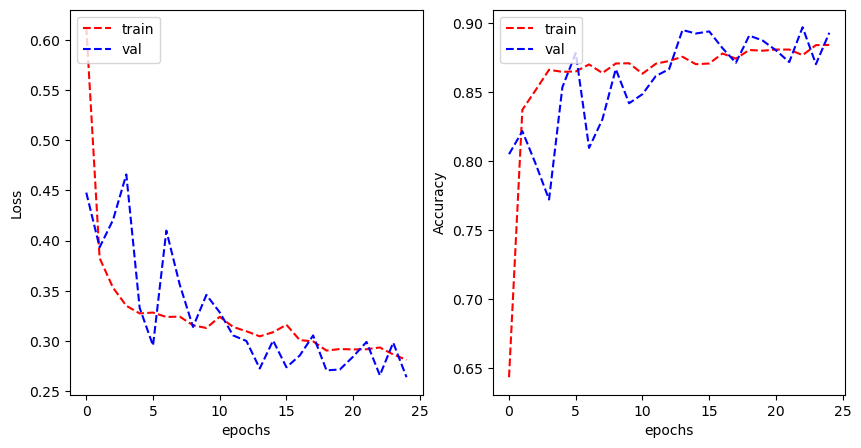

In [82]:
plot_learning_curve(history_ICDA.history['loss'], history_ICDA.history['val_loss'], 
                    history_ICDA.history['accuracy'], history_ICDA.history['val_accuracy'], 
                    metric_name='Accuracy')

In [83]:
model_ICDA.evaluate(train_generator)
model_ICDA.evaluate(validation_generator)
ICDA = model_ICDA.evaluate(test_generator)
print("VGG3: 0.9090909361839294")
print("ICDA: " + str(ICDA[1]))

62/62 [==============================] - 1s 17ms/step - loss: 0.2586 - accuracy: 0.8909
VGG3: 0.9090909361839294
ICDA: 0.8909090757369995


In [84]:
#Code to store the model and weights 
model_ICDA.save('output/ICDA.h5')
model_ICDA.save_weights('output/ICDA_weights.h5')

## Hyperparameter Tuning

Since Data Augmentation shows lower accuracy compare to original one. Reverting the data back to original for further parameter tuning

In [85]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


### Changing compiler parameter

In [86]:
model_ICCP = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [87]:
model_ICCP.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    decay=1e-6)
,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [88]:
history_ICCP = model_ICCP.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

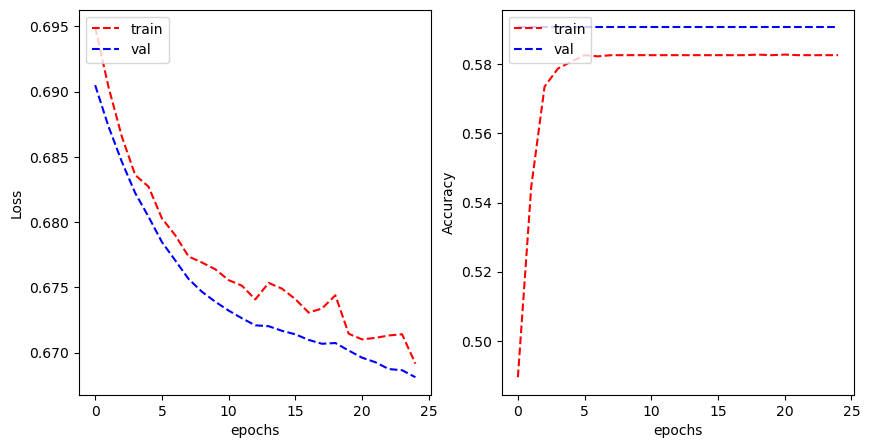

In [89]:
plot_learning_curve(history_ICCP.history['loss'], history_ICCP.history['val_loss'], 
                    history_ICCP.history['accuracy'], history_ICCP.history['val_accuracy'], 
                    metric_name='Accuracy')

In [90]:
model_ICCP.evaluate(train_generator)
model_ICCP.evaluate(validation_generator)
ICCP = model_ICCP.evaluate(test_generator)
print("VGG3: 0.9090909361839294")
print("ICCP: " + str(ICCP[1]))

62/62 [==============================] - 1s 9ms/step - loss: 0.6662 - accuracy: 0.6005
VGG3: 0.9090909361839294
ICCP: 0.6005050539970398


In [91]:
#Code to store the model and weights 
model_ICCP.save('output/ICCP.h5')
model_ICCP.save_weights('output/ICCP_weights.h5')

Since VGG3 has higher accuracy than adjusted compiler parameter, compiler parameter won't be changed

### Using early stopping

In [92]:
model_ICES = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [93]:
model_ICES.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [94]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, min_delta=0.000001)

In [95]:
history_ICES = model_ICES.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0, callbacks=[callback])

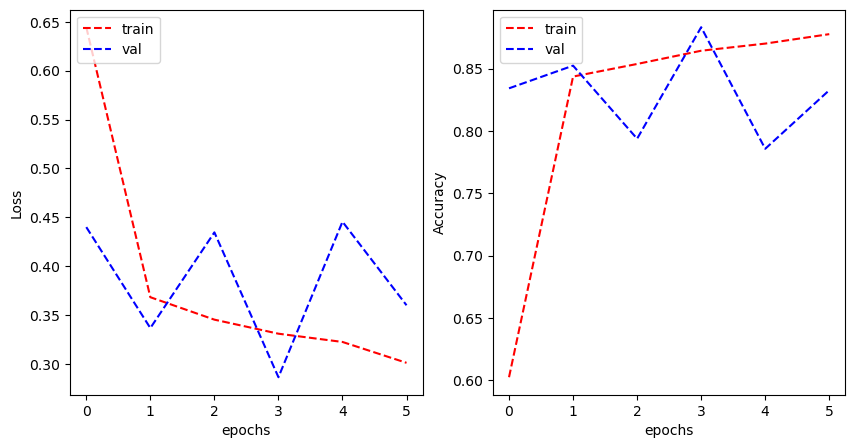

In [96]:
plot_learning_curve(history_ICES.history['loss'], history_ICES.history['val_loss'], 
                    history_ICES.history['accuracy'], history_ICES.history['val_accuracy'], 
                    metric_name='Accuracy')

In [97]:
model_ICES.evaluate(train_generator)
model_ICES.evaluate(validation_generator)
ICES = model_ICES.evaluate(test_generator)
print("VGG3: 0.9090909361839294")
print("ICES: " + str(ICES[1]))

62/62 [==============================] - 0s 7ms/step - loss: 0.2822 - accuracy: 0.8944
VGG3: 0.9090909361839294
ICES: 0.894444465637207


In [98]:
#Code to store the model and weights 
model_ICES.save('output/ICES.h5')
model_ICES.save_weights('output/ICES_weights.h5')

early stopping doesn't improve the accuracy

### Epochs adjustment

In [99]:
def epochs_adjustment(epochs):
    model_ICEA = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 3
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model_ICEA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    history_ICEA = model_ICEA.fit(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)
    
    plot_learning_curve(history_ICEA.history['loss'], history_ICEA.history['val_loss'], 
                    history_ICEA.history['accuracy'], history_ICEA.history['val_accuracy'], 
                    metric_name='Accuracy')
    
    model_ICEA.evaluate(train_generator)
    model_ICEA.evaluate(validation_generator)
    test_acc = model_ICEA.evaluate(test_generator)
    print("VGG3: 0.9090909361839294")
    print("ICEA: " + str(test_acc[1]))
    
    return test_acc[1], model_ICEA

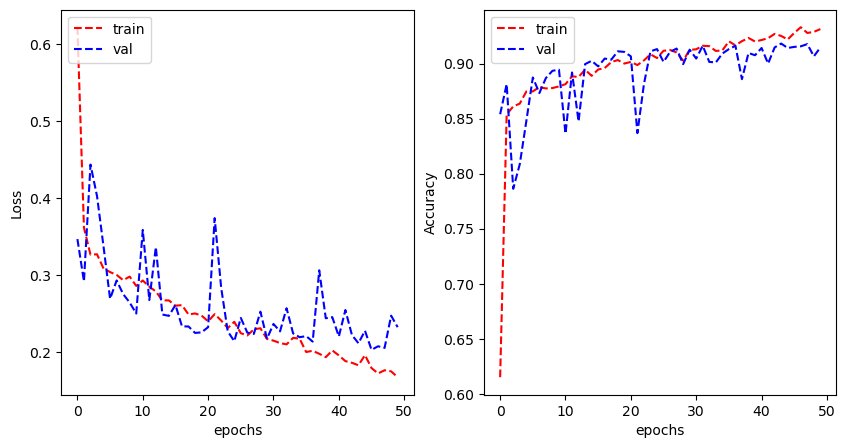

62/62 [==============================] - 1s 8ms/step - loss: 0.2416 - accuracy: 0.9116
VGG3: 0.9090909361839294
ICEA: 0.9116161465644836


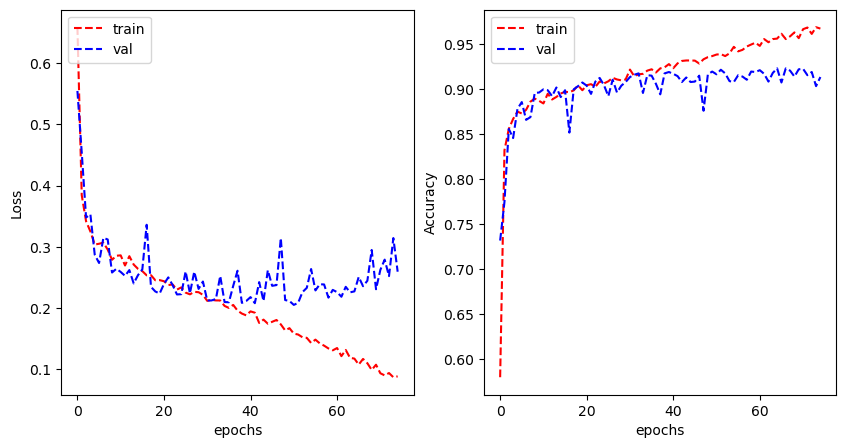

62/62 [==============================] - 1s 9ms/step - loss: 0.2705 - accuracy: 0.9167
VGG3: 0.9090909361839294
ICEA: 0.9166666865348816


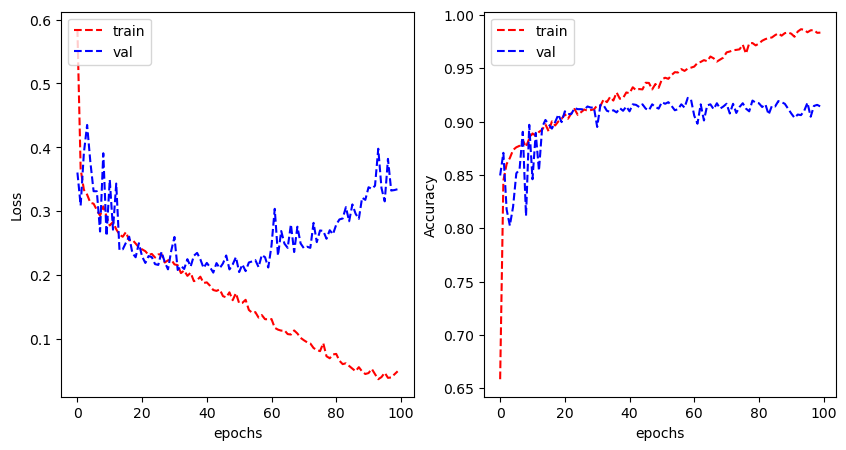

62/62 [==============================] - 0s 7ms/step - loss: 0.3920 - accuracy: 0.9020
VGG3: 0.9090909361839294
ICEA: 0.9020202159881592


In [100]:
epochs_list = [50, 75, 100]
max_acc = 0
best_ICEA = None

for epochs in epochs_list:
    model_acc, model = epochs_adjustment(epochs)
    
    if model_acc > max_acc:
        max_acc = model_acc
        best_ICEA = model 
        print("best_ICEA epochs=" + str(epochs) + " saved.")
        
best_ICEA.save('output/ICEA.h5')
best_ICEA.save_weights('output/ICEA_weights.h5')

Although the accuracy when epochs is 75 shows the highest accuracy, the graph shows that the model is overfitting. Therefore, epochs will be set to 50 as it is showing the best accuracy without overfitting.

### Altering Lambda and Learning Rate

In [101]:
def parmeter_tuning(hp):
    Lambda = hp.Float("lambda", min_value=1e-5, max_value=1e2, sampling="log")

    model_ICLL = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 3
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=regularizers.l2(Lambda)),
    ])
    
    lr= hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    model_ICLL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                        metrics=['accuracy'])
    
    return model_ICLL

In [102]:
parmeter_tuning(keras_tuner.HyperParameters())

In [103]:
tuner = keras_tuner.RandomSearch(
    hypermodel=parmeter_tuning,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="./patch_images/",
    project_name="Task1_ParameterTuning",
)

In [104]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
lamda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 100.0, 'step': None, 'sampling': 'log'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [105]:
tuner.search(train_generator, epochs=50, validation_data=validation_generator)

Trial 3 Complete [00h 09m 22s]
val_accuracy: 0.9193195104598999

Best val_accuracy So Far: 0.9193195104598999
Total elapsed time: 00h 27m 54s
INFO:tensorflow:Oracle triggered exit


In [108]:
tuner.results_summary()

Results summary
Results in ./patch_images/Task1_ParameterTuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
lamda: 1.559154227535136e-05
lr: 0.00034644529134644005
Score: 0.9193195104598999

Trial 0 summary
Hyperparameters:
lamda: 0.0015479097116218362
lr: 0.004773772481650521
Score: 0.5907023549079895

Trial 1 summary
Hyperparameters:
lamda: 1.6291537419311672
lr: 0.0007585705668400841
Score: 0.5907023549079895


Based on this the best parameter is the following:
- lambda: 1.559154227535136e-05
- learning rate: 0.00034644529134644005
- epochs: 50

Based on the hyperparameter tuned model, the following model is the final model with the highest accuracy to predict 'isCancerous'

## Final Model

In [109]:
Lambda = 1.559154227535136e-05

model_ICFinal = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu', kernel_regularizer=regularizers.l2(Lambda)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=regularizers.l2(Lambda)),
])

In [112]:
model_ICFinal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [113]:
history_ICFinal = model_ICFinal.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

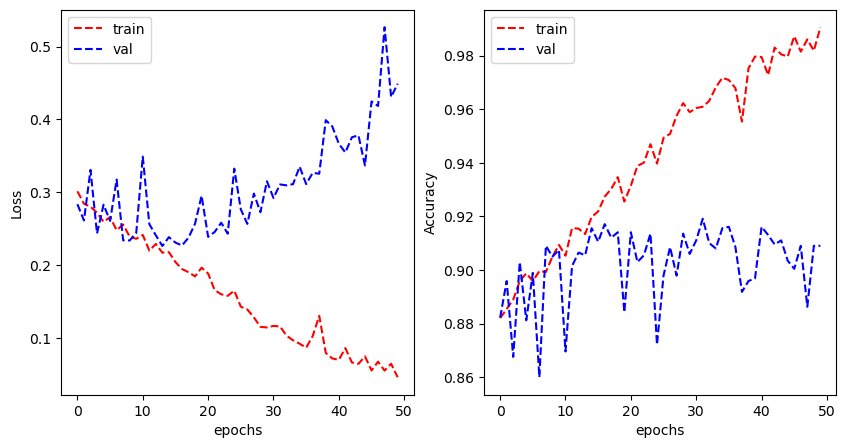

In [114]:
plot_learning_curve(history_ICFinal.history['loss'], history_ICFinal.history['val_loss'], 
                    history_ICFinal.history['accuracy'], history_ICFinal.history['val_accuracy'], 
                    metric_name='Accuracy')

In [115]:
model_ICFinal.evaluate(train_generator)
model_ICFinal.evaluate(validation_generator)
model_ICFinal.evaluate(test_generator)

62/62 [==============================] - 1s 8ms/step - loss: 0.4276 - accuracy: 0.9192


[0.42757493257522583, 0.9191918969154358]

In [116]:
#Code to store the model and weights 
model_ICFinal.save('output/ICFinal.h5')
model_ICFinal.save_weights('output/ICFinal_weights.h5')

## Predict isCancerous from test set

In [117]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


In [118]:
label_names = {'No' : 0, 'Yes' : 1}

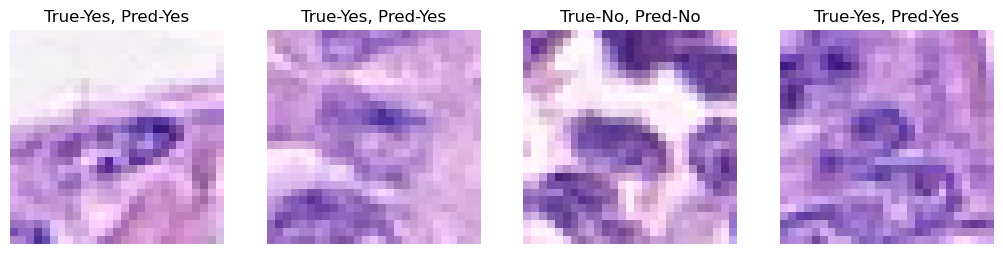

In [119]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_ICFinal.predict(x, verbose=0) # Change the model to the best one
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("True-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Target: CellTypeName

## Data Pre-Processing

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [ ]:
train_data['cellTypeName'] = train_data['cellTypeName'].astype('str')
val_data['cellTypeName'] = val_data['cellTypeName'].astype('str')
test_data['cellTypeName'] = test_data['cellTypeName'].astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

## Train the Base model

In [ ]:
model_baseCT = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model_baseCT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_baseCT = model_baseCT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_baseCT.history['loss'], history_baseCT.history['val_loss'], 
                    history_baseCT.history['categorical_accuracy'], history_baseCT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_baseCT.evaluate(train_generator)
model_baseCT.evaluate(validation_generator)
model_baseCT.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_baseCT.save('output/baseCT.h5')
model_baseCT.save_weights('output/baseCT_weights.h5')

## Alex_Net Model

### Alex_Net

In [ ]:
model_AlexNetCT = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(27, (11,11), strides=(4,4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(54, (5,5), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(108, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(108, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(216, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(432, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(432, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_AlexNetCT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [ ]:
history_AlexNetCT = model_AlexNetCT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_AlexNetCT.history['loss'], history_AlexNetCT.history['val_loss'], 
                    history_AlexNetCT.history['categorical_accuracy'],history_AlexNetCT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_AlexNetCT.evaluate(train_generator)
model_AlexNetCT.evaluate(validation_generator)
model_AlexNetCT.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_AlexNetCT.save('output/AlexNetCT.h5')
model_AlexNetCT.save_weights('output/AlexNetCT_weights.h5')

## RCC_Net Model

In [ ]:
model_RCCNetCT = Sequential()
model_RCCNetCT.add(Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Conv2D(32, (3, 3), activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(MaxPooling2D(pool_size=(2, 2)))

model_RCCNetCT.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Conv2D(64, (3, 3), activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(MaxPooling2D(pool_size=(2, 2)))
model_RCCNetCT.add(Flatten())
model_RCCNetCT.add(Dense(512, activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Dropout(0.2))
model_RCCNetCT.add(Dense(512, activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Dropout(0.2))
model_RCCNetCT.add(Dense(4, activation='softmax'))

In [ ]:
model_RCCNetCT.compile(loss="categorical_crossentropy", metrics=["categorical_accuracy"], optimizer="adam")

In [ ]:
history_RCCNetCT = model_RCCNetCT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_RCCNetCT.history['loss'], history_RCCNetCT.history['val_loss'], 
                    history_RCCNetCT.history['categorical_accuracy'],history_RCCNetCT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_RCCNetCT.evaluate(train_generator)
model_RCCNetCT.evaluate(validation_generator)
model_RCCNetCT.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_RCCNetCT.save('output/RCCNetCT.h5')
model_RCCNetCT.save_weights('output/RCCNetCT_weights.h5')

## VGG Model

### VGG 2 Blocks

In [10]:
model_VGG2CT.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 27, 27, 27)        756       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 27, 27, 54)        13176     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 54)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 54)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 13, 13, 54)        26298     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 13, 13, 108)       52596     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 108)        

In [9]:
model_VGG2CT = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG2CT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [ ]:
history_VGG2CT = model_VGG2CT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_VGG2CT.history['loss'], history_VGG2CT.history['val_loss'], 
                    history_VGG2CT.history['categorical_accuracy'], history_VGG2CT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG2CT.evaluate(train_generator)
model_VGG2CT.evaluate(validation_generator)
model_VGG2CT.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_VGG2CT.save('output/VGG2CT.h5')
model_VGG2CT.save_weights('output/VGG2CT_weights.h5')

## ANN Model

### ANN 3 Hidden Layers

In [ ]:
model_ANN3CT = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
model_ANN3CT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['categorical_accuracy'])

In [ ]:
history_ANN3CT = model_ANN3CT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_ANN3CT.history['loss'], history_ANN3CT.history['val_loss'], 
                    history_ANN3CT.history['categorical_accuracy'], history_ANN3CT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_ANN3CT.evaluate(train_generator)
model_ANN3CT.evaluate(validation_generator)
model_ANN3CT.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_ANN3CT.save('output/ANN3CT.h5')
model_ANN3CT.save_weights('output/ANN3CT_weights.h5')

### Overall Result

In [ ]:
baseCT = model_baseCT.evaluate(test_generator)[1]
AlexNetCT = model_AlexNetCT.evaluate(test_generator)[1]
RCCNetCT = model_RCCNetCT.evaluate(test_generator)[1]
VGG2CT = model_VGG2CT.evaluate(test_generator)[1]
ANN3CT = model_ANN3CT.evaluate(test_generator)[1]

print("base: " + str(baseCT))
print("AlexNet: " + str(AlexNetCT))
print("RCCNet: " + str(RCCNetCT))
print("VGG2: " + str(VGG2CT))
print("ANN3: " + str(ANN3CT))

VGG2 is slected for hyperparameter tuning

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.15,
                                   rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model_CTDA = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_CTDA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [ ]:
history_CTDA = model_CTDA.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_CTDA.history['loss'], history_CTDA.history['val_loss'], 
                    history_CTDA.history['categorical_accuracy'], history_CTDA.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_CTDA.evaluate(train_generator)
model_CTDA.evaluate(validation_generator)
model_CTDA.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_CTDA.save('output/CTDA.h5')
model_CTDA.save_weights('output/CTDA_weights.h5')

## Hyperparameters Tuning

### Changing compiler parameter

In [ ]:
model_CTCP = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_CTCP.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    decay=1e-6)
,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['categorical_accuracy'])

In [ ]:
history_CTCP = model_CTCP.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_CTCP.history['loss'], history_CTCP.history['val_loss'], 
                    history_CTCP.history['categorical_accuracy'], history_CTCP.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_CTCP.evaluate(train_generator)
model_CTCP.evaluate(validation_generator)
model_CTCP.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_CTCP.save('output/CTCP.h5')
model_CTCP.save_weights('output/CTCP_weights.h5')

### Using earlystopping

In [ ]:
model_CTES = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_CTES.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, min_delta=0.000001)

In [ ]:
history_CTES = model_CTES.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0, callbacks=[callback])

In [ ]:
plot_learning_curve(history_CTES.history['loss'], history_CTES.history['val_loss'], 
                    history_CTES.history['categorical_accuracy'], history_CTES.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_CTES.evaluate(train_generator)
model_CTES.evaluate(validation_generator)
model_CTES.evaluate(test_generator)

In [ ]:
#Code to store the model and weights 
model_CTES.save('output/CTES.h5')
model_CTES.save_weights('output/CTES_weights.h5')

### Hyperparameter Tuning Results

In [ ]:
CTDA = model_CTDA.evaluate(test_generator)[1]
CTCP = model_CTCP.evaluate(test_generator)[1]
CTES = model_CTES.evaluate(test_generator)[1]

print("VGG2: 0.7530303001403809")
print("Data Augmentation: " + str(CTDA))
print("Compiler Parameter: " + str(CTCP))
print("Early Stopping: " + str(CTES))

### Epochs adjustment

In [ ]:
def epochs_adjustment(epochs):
    model_ICEA = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model_ICEA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])
    
    history_ICEA = model_ICEA.fit(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)
    
    plot_learning_curve(history_ICEA.history['loss'], history_ICEA.history['val_loss'], 
                    history_ICEA.history['categorical_accuracy'], history_ICEA.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    model_ICEA.evaluate(train_generator)
    model_ICEA.evaluate(validation_generator)
    test_acc = model_ICEA.evaluate(test_generator)
    
    return test_acc[1], model_ICEA

In [ ]:
epochs_list = [50, 75, 100]
max_acc = 0
best_ICEA = None

for epochs in epochs_list:
    model_acc, model = epochs_adjustment(epochs)
    
    if model_acc > max_acc:
        max_acc = model_acc
        best_ICEA = model 
        
best_ICEA.save('output/ICEA.h5')
best_ICEA.save_weights('output/ICEA_weights.h5')

### Altering Parameters

In [ ]:
def parmeter_tuning(hp):
    Lambda = hp.Float("lamda", min_value=1e-5, max_value=1e2, sampling="log")

    model_ICAP = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    lr= hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    model_ICAP.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics=['categorical_accuracy'])
    
    return model_ICAP

In [ ]:
parmeter_tuning(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=parmeter_tuning,
    objective="val_categorical_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="./patch_images/",
    project_name="Task1_ParameterTuning",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_generator, epochs=25, validation_data=validation_generator)

# Predict cellTypeName from test set

VGG2 shows the highest accuracy before data augmentation. It will be used for visualization.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_VGG2CT.predict(x, verbose=0) # Change to the best model
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("True-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## Extra + Main dataset

### Data Load

In [ ]:
# new_df = extra + Main - Main['celltype']
extra_df = pd.read_csv("data_labels_extraData.csv", delimiter=',')

In [ ]:
df_extra_data = extra_df.copy()

In [ ]:
df_extra_data.head(5)

In [ ]:
df_extra_data.shape

### Data Pre-Processing

In [ ]:
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

extra_generator = extra_datagen.flow_from_dataframe(
        dataframe=df_extra_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col=None,
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='input')

In [ ]:
model_VGG2CT.summary() # change to the best model

In [ ]:
VGG2CT_pred = model_VGG2CT.predict(extra_generator)

In [ ]:
cell_type_names = ['fibroblast', 'inflammatory', 'epithelial', 'others']

confidence_level = np.max(VGG2CT_pred, axis=1)
max_indices = np.argmax(VGG2CT_pred, axis=1)
cell_type_preds = [cell_type_names[i] for i in max_indices]

In [ ]:
df_extra_data['cellTypeName'] = cell_type_preds
df_extra_data['cellType'] = max_indices
df_extra_data['confidenceLevel'] = confidence_level
df_extra_data.head(5)

In [ ]:
threshold = 2
df_extra_data = df_extra_data[df_extra_data['confidenceLevel'] >= threshold]

In [ ]:
print(str(len(VGG2CT_pred) - df_extra_data.shape[0]) + " rows removed.")
print(df_extra_data.shape)
df_extra_data.head(5)

In [ ]:
df_extra_data = df_extra_data.drop('confidenceLevel', axis=1)
df_extra_data.head(5)

In [ ]:
df_cancer_data.head(5)

In [ ]:
df_main_extra = pd.concat([df_cancer_data, df_extra_data], axis=0)
df_main_extra.reset_index(drop=True, inplace=True)

In [ ]:
df_main_extra.shape

In [ ]:
print(df_cancer_data.shape[0] + df_extra_data.shape[0])

In [ ]:
df_main_extra.head(5)

In [ ]:
with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(df_main_extra, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [ ]:
train_data['cellTypeName'] = train_data['cellTypeName'].astype('str')
val_data['cellTypeName'] = val_data['cellTypeName'].astype('str')
test_data['cellTypeName'] = test_data['cellTypeName'].astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.15,
                                   rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

### VGG 2 Blocks

In [ ]:
model_VGG2_extra = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG2_extra.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [ ]:
history_VGG2_extra = model_VGG2_extra.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

In [ ]:
plot_learning_curve(history_VGG2_extra.history['loss'], history_VGG2_extra.history['val_loss'], 
                    history_VGG2_extra.history['categorical_accuracy'], history_VGG2_extra.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG2_extra.evaluate(train_generator)
model_VGG2_extra.evaluate(validation_generator)
VGG2_extra = model_VGG2_extra.evaluate(test_generator)[1]
print("VGG2: 0.7530303001403809")
print("VGG2_extra: " + str(VGG2_extra))

In [ ]:
#Code to store the model and weights 
model_VGG2_extra.save('output/VGG2_extra.h5')
model_VGG2_extra.save_weights('output/VGG2_extra_weights.h5')